In [ ]:
# !git clone https://github.com/MandaKausthubh/GSOC-25-Projects.git

Cloning into 'GSOC-25-Projects'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 110 (delta 60), reused 66 (delta 26), pack-reused 6 (from 1)
Receiving objects: 100% (110/110), 1.13 MiB | 8.21 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [ ]:
# %cd GSOC-25-Projects

/content/GSOC-25-Projects


In [ ]:
#!pip install -q gdown  # Ensure gdown is installed
#!gdown "https://drive.google.com/uc?id=1znqUeFzYz-DeAE3dYXD17qoMPK82Whji"
#!unzip -q Dataset.zip

# 1znqUeFzYz-DeAE3dYXD17qoMPK82Whji

# from google.colab import drive
# drive.mount('/content/drive')

# !cp /content/drive/MyDrive/"Dataset.zip" /content/GSOC-25-Projects/
# !unzip -q Dataset.zip

Mounted at /content/drive


In [ ]:
# !rm -fr Dataset.zip __MACOSX/
# !mkdir dataset
# !mv Dataset dataset/

In [ ]:
# !mv dataset/Dataset/ dataset/DatasetTask6A

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp /content/drive/MyDrive/"DatasetB.zip" /content/GSOC-25-Projects/
# !unzip -q DatasetB.zip
# !rm -fr DatasetB.zip __MACOSX/
# !mkdir dataset
# !mv Dataset DatasetB
# !mv DatasetB dataset/
# !mv dataset/DatasetB/ dataset/DatasetTask6B

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘dataset’: File exists


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Normalize, Lambda
import torchvision

import sys, os
sys.path.append(os.path.join(os.path.dirname("./"), '..'))

from utils.Training import Train_MAE
from utils.CustomDataset import CustomDatasetSelfSupervised
from Models.MaskedAutoEncoders import MaskedAutoEncoder
from utils.Augmentation import augment_images

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
# Transform = Normalize(mean=[0.5], std=[0.5])
class MinMaxNormalize(object):
    """Normalizes a tensor to [0, 1] range using min and max of the tensor."""
    def __init__(self, min_val=None, max_val=None):
        """
        Args:
            min_val (float, optional): Fixed min value. If None, computed from input.
            max_val (float, optional): Fixed max value. If None, computed from input.
        """
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, tensor):
        """
        Args:
            tensor (torch.Tensor): Input tensor of shape (C, H, W) or (H, W)
        Returns:
            torch.Tensor: Normalized tensor in [0, 1]
        """
        if self.min_val is None or self.max_val is None:
            min_val = tensor.min()
            max_val = tensor.max()
        else:
            min_val = self.min_val
            max_val = self.max_val

        # Avoid division by zero
        if max_val == min_val:
            return torch.zeros_like(tensor) if min_val == 0 else torch.ones_like(tensor)

        return (tensor - min_val) / (max_val - min_val)

In [4]:
def visualize_reconstruction(model, data, index=0, mask_ratio=0.75, patch_size=8, device='cpu'):
    """
    Visualize the original image, mask, and reconstructed image from the MAE model.

    Args:
        model: Trained MaskedAutoEncoder instance
        data: Dataset or list of images (tensors of shape (C, H, W))
        index: Index of the image to visualize (default: 0)
        mask_ratio: Fraction of patches to mask (default: 0.75)
        patch_size: Size of each patch (default: 16). Can be an integer (square patches) or tuple (rectangular patches).
        device: Device to run the model on (default: 'cpu')
    """
    model.eval()
    with torch.no_grad():
        image = data[index].unsqueeze(0).to(device)  # (1, C, H, W)
        loss, pred, mask = model(image, mask_ratio)
        recon = model.unpatchify(pred)  # (1, C, H, W)

        # Get image size
        _, C, H, W = image.shape

        # Handle patch_size as integer or tuple
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        else:
            assert len(patch_size) == 2, "patch_size must be an integer or a tuple of two integers"

        # Calculate number of patches
        num_patches_h = H // patch_size[0]
        num_patches_w = W // patch_size[1]

        # Reshape mask for visualization
        mask_vis = mask.reshape(1, num_patches_h, num_patches_w).squeeze().cpu()

        # Plot original, mask, and reconstruction
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        if C == 1:
            axes[0].imshow(image.squeeze().cpu())
        else:
            axes[0].imshow(image.squeeze().cpu().permute(1, 2, 0))
        axes[0].set_title('Original')

        # Mask
        axes[1].imshow(mask_vis)
        axes[1].set_title('Mask')

        # Reconstructed image
        if C == 1:
            axes[2].imshow(recon.squeeze().cpu())
        else:
            axes[2].imshow(recon.squeeze().cpu().permute(1, 2, 0))
        axes[2].set_title('Reconstructed')

        plt.show()

In [5]:
from torch.optim.lr_scheduler import LambdaLR

def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """
    Creates a learning rate scheduler with:
    - Warmup (linear increase from 0 to initial LR) over `num_warmup_steps`.
    - Linear decay to 0 over remaining `num_training_steps - num_warmup_steps`.
    """
    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            # Warmup phase: increase LR from 0 to 1.0
            return float(current_step) / float(max(1, num_warmup_steps))
        # Decay phase: decrease LR from 1.0 to 0.0
        return max(
            0.0,
            float(num_training_steps - current_step) /
            float(max(1, num_training_steps - num_warmup_steps)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

In [ ]:
Data_paths = [os.path.join(root, file) for root, _, files in os.walk( "../dataset/DatasetTask6A/no_sub") for file in files]
# Data_paths = Data_paths[:1000]

transform = torchvision.transforms.Compose([
    MinMaxNormalize(),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
])

dataset = CustomDatasetSelfSupervised(
      data = Data_paths,
      root = "",
      transform = transform,
)

len(dataset), dataset[0].shape

(29449, torch.Size([1, 64, 64]))

In [7]:
train_len = int(len(dataset)*0.9)
test_len = len(dataset) - train_len


train, test = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))
TrainLoader = DataLoader(train, batch_size=256,
                         shuffle=True, num_workers=1, pin_memory=True,
                         persistent_workers=True, drop_last=True)
ValidationLoader = DataLoader(test, batch_size=256,
                              shuffle=False, num_workers=1,
                              pin_memory=True, drop_last=True,
                              persistent_workers=True)

In [8]:
# Define the model

device = "cuda"

model = MaskedAutoEncoder(
        patch_size=16,
        encoder_embedding_dim=2048, encoder_num_heads=64, encoder_depth=8,
        decoder_embedding_dim=1024, decoder_num_heads=32, decoder_depth=6
    ).to(device=device)

model.compile()

In [9]:
model.norm_pix_loss = False
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05, betas=(0.9, 0.95))

total_epochs = 500
batches_per_epoch = len(TrainLoader)
total_training_steps = total_epochs * batches_per_epoch
num_warmup_steps = int(total_training_steps * 0.4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, total_training_steps)

Train_MAE(model, TrainLoader, ValidationLoader, 0.5, optimizer,
            epochs=total_epochs, device='cuda', scheduler=scheduler)

Validating Epoch 500/500: 100%|██████████| 11/11 [00:02<00:00,  3.91it/s, loss=0.0021]


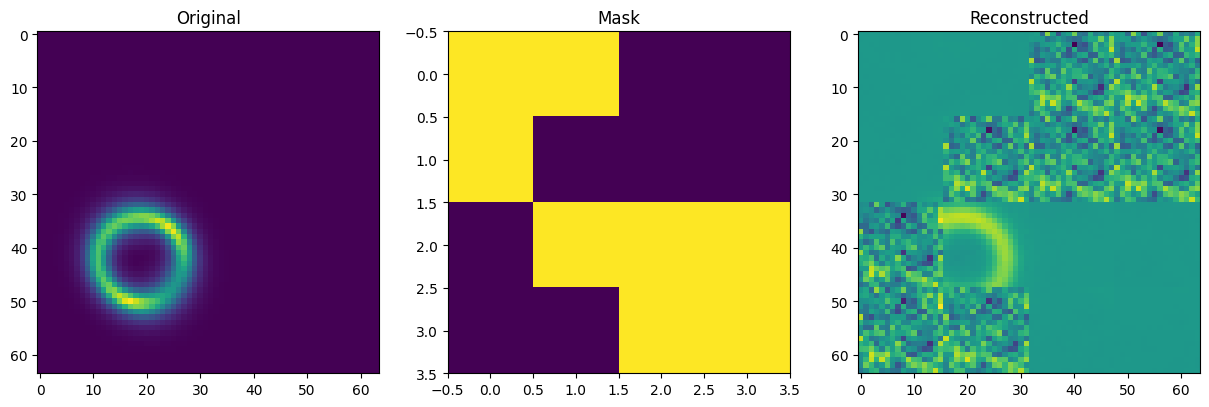

In [10]:
torch.set_float32_matmul_precision('high')
visualize_reconstruction(model, train, index=0, mask_ratio=0.5, patch_size=16, device=device)

In [ ]:
torch.save(model.state_dict(), 'MaskedAutoEncoder__Very_VeryDeep_Final__Solution.pth')

In [12]:
image = train[4].unsqueeze(0).to(device)  # (1, 1, 64, 64)
latent, _, _ = model.forward_encoder(image, masking_ratio=0.75)
print(latent.shape)  # Should be (1, 4, 768) - 4 unmasked patches
print(latent.var(dim=1).mean())  # Variance across patches

torch.Size([1, 4, 2048])
tensor(14.9090, device='cuda:0', grad_fn=<MeanBackward0>)


In [13]:
print("Decoder Positional Embeddings Variance:", model.decoder_pos_embed.var(dim=1).mean().item())

Decoder Positional Embeddings Variance: 0.19542153179645538


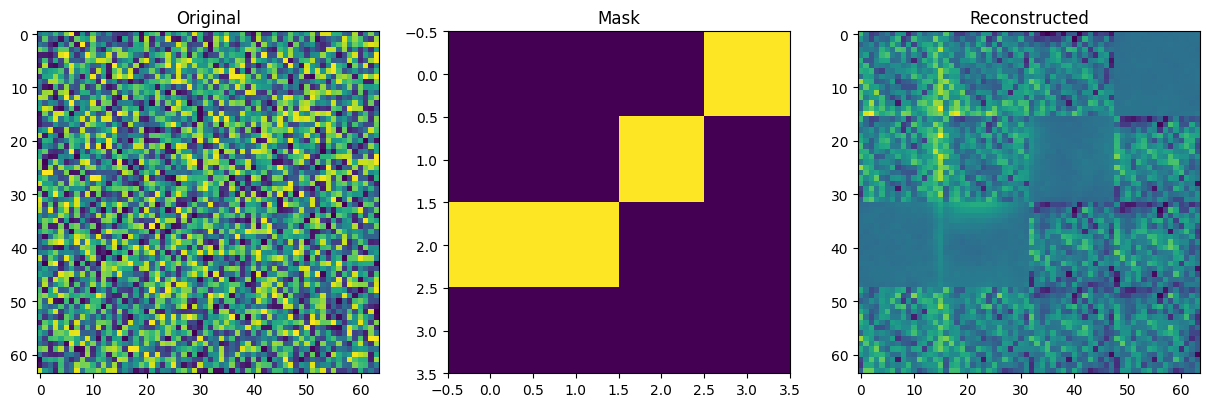

In [14]:
TestingData = torch.rand(4, 1, 64, 64).to(device)
visualize_reconstruction(model, TestingData, index=2, mask_ratio=0.3, patch_size=16, device=device)

In [ ]:
# !mv MaskedAutoEncoder__Very_VeryDeep_Final__Solution.pth /content/drive/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# import sys, os
# sys.path.append(os.path.join(os.path.dirname("./"), '..'))

Data = []
labels = []

for root, dirs, _ in os.walk('../dataset/DatasetTask6A/'):
    for dir in dirs:
        for root2, _, files in os.walk(os.path.abspath(os.path.join(root, dir))):
            for file in files:
                Data.append(os.path.abspath(os.path.join(root2, file)))
                labels.append(dir)

# Data = Data[:100]
# labels = labels[:100]

print("Number of files: ", len(Data))
print("Number of labels: ", len(labels))

In [ ]:
from utils.CustomDataset import CustomDataset
from utils.Training import Train
from Models.MAEClassifier import MAEViTClassifier
from Models.MaskedAutoEncoders import MaskedAutoEncoder


Dataset = CustomDataset(
    root='../dataset/DatasetTask6A/',
    data=Data,
    label=labels,
    label_to_id = {'axion': 0, 'cdm':1, 'no_sub':2},
    transforms=None,
    label_transform=None,
)

train, test = torch.utils.data.random_split(Dataset, [int(len(Dataset)*0.8), len(Dataset) - int(len(Dataset)*0.8)])

trainloader = torch.utils.data.DataLoader(
    train,
    batch_size=128,
    shuffle=True,
    num_workers=2,
)

testloader = torch.utils.data.DataLoader(
    test,
    batch_size=128,
    shuffle=True,
    num_workers=2,
)

In [23]:
ClassifierModel = MAEViTClassifier(
    Encoder=model,
    num_classes=3,
    hidden_size=1024
).to(device='cuda')

Created Classifier


In [26]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

Train(ClassifierModel, trainloader, testloader, criterion, optimizer, epochs=100, device='cuda', scheduler=None)

Validating: 100%|██████████| 140/140 [00:03<00:00, 44.59it/s]


Epoch 1: Validation Loss = 0.3243


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.61it/s]


Epoch 2: Validation Loss = 0.2527


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.47it/s]


Epoch 3: Validation Loss = 0.2968


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.70it/s]


Epoch 4: Validation Loss = 0.3083


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.76it/s]


Epoch 5: Validation Loss = 0.3131


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.71it/s]


Epoch 6: Validation Loss = 0.1948


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.57it/s]


Epoch 7: Validation Loss = 0.2030


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.69it/s]


Epoch 8: Validation Loss = 0.2317


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.65it/s]


Epoch 9: Validation Loss = 0.1917


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.73it/s]


Epoch 10: Validation Loss = 0.1703


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.73it/s]


Epoch 11: Validation Loss = 0.1622


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.76it/s]


Epoch 12: Validation Loss = 0.1519


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.71it/s]


Epoch 13: Validation Loss = 0.1932


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.52it/s]


Epoch 14: Validation Loss = 0.1783


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.34it/s]


Epoch 15: Validation Loss = 0.1372


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.61it/s]


Epoch 16: Validation Loss = 0.1965


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.67it/s]


Epoch 17: Validation Loss = 0.1365


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.61it/s]


Epoch 18: Validation Loss = 0.2590


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.52it/s]


Epoch 19: Validation Loss = 0.2613


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.44it/s]


Epoch 20: Validation Loss = 0.2129


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.44it/s]


Epoch 21: Validation Loss = 0.1666


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.52it/s]


Epoch 22: Validation Loss = 0.1280


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.24it/s]


Epoch 23: Validation Loss = 0.1497


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.54it/s]


Epoch 24: Validation Loss = 0.1304


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.43it/s]


Epoch 25: Validation Loss = 0.2469


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.59it/s]


Epoch 26: Validation Loss = 0.1461


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.61it/s]


Epoch 27: Validation Loss = 0.1042


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.57it/s]


Epoch 28: Validation Loss = 0.1444


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.52it/s]


Epoch 29: Validation Loss = 0.1461


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.23it/s]


Epoch 30: Validation Loss = 0.1504


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.37it/s]


Epoch 31: Validation Loss = 0.1268


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.37it/s]


Epoch 32: Validation Loss = 0.1113


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.62it/s]


Epoch 33: Validation Loss = 0.1500


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.50it/s]


Epoch 34: Validation Loss = 0.1879


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.36it/s]


Epoch 35: Validation Loss = 0.1130


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.56it/s]


Epoch 36: Validation Loss = 0.1345


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.59it/s]


Epoch 37: Validation Loss = 0.1382


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.50it/s]


Epoch 38: Validation Loss = 0.0860


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.47it/s]


Epoch 39: Validation Loss = 0.1208


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.47it/s]


Epoch 40: Validation Loss = 0.1404


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.45it/s]


Epoch 41: Validation Loss = 0.1039


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.53it/s]


Epoch 42: Validation Loss = 0.0986


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.41it/s]


Epoch 43: Validation Loss = 0.0791


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.25it/s]


Epoch 44: Validation Loss = 0.1036


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.37it/s]


Epoch 45: Validation Loss = 0.1085


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.56it/s]


Epoch 46: Validation Loss = 0.2076


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.46it/s]


Epoch 47: Validation Loss = 0.0936


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.28it/s]


Epoch 48: Validation Loss = 0.1371


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.48it/s]


Epoch 49: Validation Loss = 0.1222


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.46it/s]


Epoch 50: Validation Loss = 0.1146


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.46it/s]


Epoch 51: Validation Loss = 0.1014


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.42it/s]


Epoch 52: Validation Loss = 0.1163


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.10it/s]


Epoch 53: Validation Loss = 0.0889


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.53it/s]


Epoch 54: Validation Loss = 0.1031


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.55it/s]


Epoch 55: Validation Loss = 0.1349


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.42it/s]


Epoch 56: Validation Loss = 0.0957


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.33it/s]


Epoch 57: Validation Loss = 0.0875


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.46it/s]


Epoch 58: Validation Loss = 0.1115


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.52it/s]


Epoch 59: Validation Loss = 0.0664


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.52it/s]


Epoch 60: Validation Loss = 0.0728


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.32it/s]


Epoch 61: Validation Loss = 0.0711


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.36it/s]


Epoch 62: Validation Loss = 0.0746


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.54it/s]


Epoch 63: Validation Loss = 0.1101


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.51it/s]


Epoch 64: Validation Loss = 0.1039


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.33it/s]


Epoch 65: Validation Loss = 0.1014


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.08it/s]


Epoch 66: Validation Loss = 0.1065


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.44it/s]


Epoch 67: Validation Loss = 0.1508


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.42it/s]


Epoch 68: Validation Loss = 0.0755


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.36it/s]


Epoch 69: Validation Loss = 0.0819


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.35it/s]


Epoch 70: Validation Loss = 0.1246


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.49it/s]


Epoch 71: Validation Loss = 0.1151


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.39it/s]


Epoch 72: Validation Loss = 0.0781


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.53it/s]


Epoch 73: Validation Loss = 0.0978


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.29it/s]


Epoch 74: Validation Loss = 0.1096


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.14it/s]


Epoch 75: Validation Loss = 0.0793


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.49it/s]


Epoch 76: Validation Loss = 0.0541


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.26it/s]


Epoch 77: Validation Loss = 0.0982


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.30it/s]


Epoch 78: Validation Loss = 0.0852


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.21it/s]


Epoch 79: Validation Loss = 0.0706


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.43it/s]


Epoch 80: Validation Loss = 0.0641


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.38it/s]


Epoch 81: Validation Loss = 0.0745


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.32it/s]


Epoch 82: Validation Loss = 0.0764


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.20it/s]


Epoch 83: Validation Loss = 0.1199


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.34it/s]


Epoch 84: Validation Loss = 0.0890


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.29it/s]


Epoch 85: Validation Loss = 0.0660


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.46it/s]


Epoch 86: Validation Loss = 0.0705


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.30it/s]


Epoch 87: Validation Loss = 0.0993


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.28it/s]


Epoch 88: Validation Loss = 0.0777


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.42it/s]


Epoch 89: Validation Loss = 0.0718


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.31it/s]


Epoch 90: Validation Loss = 0.0956


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.27it/s]


Epoch 91: Validation Loss = 0.0878


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.42it/s]


Epoch 92: Validation Loss = 0.0907


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.26it/s]


Epoch 93: Validation Loss = 0.0757


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.11it/s]


Epoch 94: Validation Loss = 0.1891


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.01it/s]


Epoch 95: Validation Loss = 0.0709


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.13it/s]


Epoch 96: Validation Loss = 0.0516


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.18it/s]


Epoch 97: Validation Loss = 0.0755


Validating: 100%|██████████| 140/140 [00:03<00:00, 43.99it/s]


Epoch 98: Validation Loss = 0.0645


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.35it/s]


Epoch 99: Validation Loss = 0.0666


Validating: 100%|██████████| 140/140 [00:03<00:00, 44.29it/s]

Epoch 100: Validation Loss = 0.0853


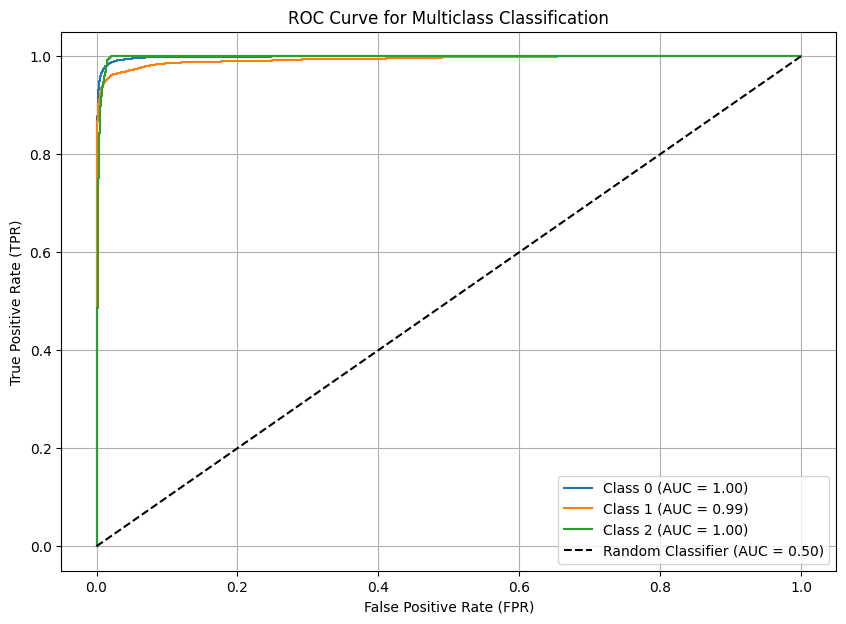

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(y_true, y_pred, num_classes):
    y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

    plt.figure(figsize=(10, 7))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve for Multiclass Classification")
    plt.legend()
    plt.grid()
    plt.show()


def evaluate_model_roc(model, dataloader, device, num_classes):
    model.eval()  # Set model to evaluation mode
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)

            y_true_list.append(labels.cpu().numpy())
            y_pred_list.append(logits.cpu().numpy())

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    plot_multiclass_roc(y_true, y_pred, num_classes)

evaluate_model_roc(ClassifierModel, testloader, device, num_classes=3)

In [ ]:
torch.save(ClassifierModel.state_dict(), 'MaskedAutoEncoderClassifier__Very_VeryDeep_Final__Solution.pth')

In [ ]:
files_HR = []
files_LR = []

for root, dirs, files in os.walk('../dataset/DatasetTask6B/HR'):
    files_HR = files

for root, dirs, files in os.walk('../dataset/DatasetTask6B/LR'):
    files_LR = files

print(len(files_HR), len(files_LR))
print(files_HR == files_LR)

10000 10000
True


In [42]:
model = MaskedAutoEncoder(
        patch_size=16,
        encoder_embedding_dim=2048, encoder_num_heads=64, encoder_depth=8,
        decoder_embedding_dim=1024, decoder_num_heads=32, decoder_depth=6
    ).to(device=device)

model.load_state_dict(torch.load('MaskedAutoEncoder__Very_VeryDeep_Final__Solution.pth'))

<All keys matched successfully>

In [43]:
from Models.MAESuperResolution import MAEforSuperResolution

modelSR = MAEforSuperResolution(
    LR_shape=(1,75,75),
    HR_shape=(1,150,150),
    MAE_ViT = model,
).to(device)

In [ ]:
from utils.CustomDataset import CustomSuperResolutionDataset

# files_LR = files_LR[:100]
dataset = CustomSuperResolutionDataset(
    root = '../dataset/DatasetTask6B',
    data=files_LR,
    transform_HR=None,
    transform_LR=None,
)

dataset[0][0].shape, dataset[0][1].shape

(torch.Size([1, 75, 75]), torch.Size([1, 150, 150]))

In [45]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=True,
)


In [46]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)
criterion = nn.MSELoss()

for img_lr, img_hr in train_dataloader:
    print(img_lr.shape, img_hr.shape)
    break

torch.Size([512, 1, 75, 75]) torch.Size([512, 1, 150, 150])


In [47]:
type(model)

Models.MaskedAutoEncoders.MaskedAutoEncoder

In [49]:
from utils.Training import Train_SuperResolution

Train_SuperResolution(
    model=modelSR,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=100,
    device='cuda'
)

Validating: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Epoch 1: Validation Loss = 0.0077


Validating: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


Epoch 2: Validation Loss = 0.0053


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 3: Validation Loss = 0.0033


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch 4: Validation Loss = 0.0019


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


Epoch 5: Validation Loss = 0.0012


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 6: Validation Loss = 0.0009


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


Epoch 7: Validation Loss = 0.0007


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch 8: Validation Loss = 0.0006


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Epoch 9: Validation Loss = 0.0005


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


Epoch 10: Validation Loss = 0.0005


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch 11: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Epoch 12: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch 13: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 14: Validation Loss = 0.0005


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch 15: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch 16: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 17: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 18: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 19: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


Epoch 20: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 21: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch 22: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Epoch 23: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch 24: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch 25: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Epoch 26: Validation Loss = 0.0007


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 27: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 28: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


Epoch 29: Validation Loss = 0.0005


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 30: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Epoch 31: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch 32: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch 33: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 34: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch 35: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Epoch 36: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch 37: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 38: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch 39: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Epoch 40: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 41: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 42: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch 43: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


Epoch 44: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch 45: Validation Loss = 0.0008


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch 46: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Epoch 47: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch 48: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 49: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch 50: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


Epoch 51: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


Epoch 52: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch 53: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


Epoch 54: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 55: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch 56: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 57: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch 58: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch 59: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch 60: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch 61: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


Epoch 62: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch 63: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch 64: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


Epoch 65: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Epoch 66: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


Epoch 67: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch 68: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


Epoch 69: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch 70: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch 71: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 72: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch 73: Validation Loss = 0.0006


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


Epoch 74: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


Epoch 75: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch 76: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch 77: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 78: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch 79: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch 80: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch 81: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 82: Validation Loss = 0.0004


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch 83: Validation Loss = 0.0010


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Epoch 84: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Epoch 85: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


Epoch 86: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch 87: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Epoch 88: Validation Loss = 0.0005


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 89: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch 90: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Epoch 91: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Epoch 92: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


Epoch 93: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 94: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch 95: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 96: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Epoch 97: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch 98: Validation Loss = 0.0002


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 99: Validation Loss = 0.0003


Validating: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

Epoch 100: Validation Loss = 0.0003


In [51]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [55]:
import torch
from torchmetrics.image import StructuralSimilarityIndexMeasure
from tqdm import tqdm  # For progress bar

def compute_ssim_dataloader(data_loader, model, device="cuda"):
    """
    Computes the average SSIM for all image pairs in a DataLoader.

    Args:
        data_loader (torch.utils.data.DataLoader): DataLoader returning (LR, HR) image pairs.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        float: Mean SSIM score over the dataset.
    """
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    ssim_scores = []

    with torch.no_grad():
      model.eval()
      # Iterate through batches
      for lr_images, hr_images in tqdm(data_loader, desc="Computing SSIM"):
        lr_images, hr_images = lr_images.to(device), hr_images.to(device)

        batch_ssim = ssim_metric(model(lr_images), hr_images)
        ssim_scores.append(batch_ssim.item())

    mean_ssim = sum(ssim_scores) / len(ssim_scores)
    return mean_ssim

mean_ssim = compute_ssim_dataloader(val_dataloader, modelSR, device="cuda")
print(f"\nMean SSIM: {mean_ssim:.4f}")

Computing SSIM: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Mean SSIM: 0.9020


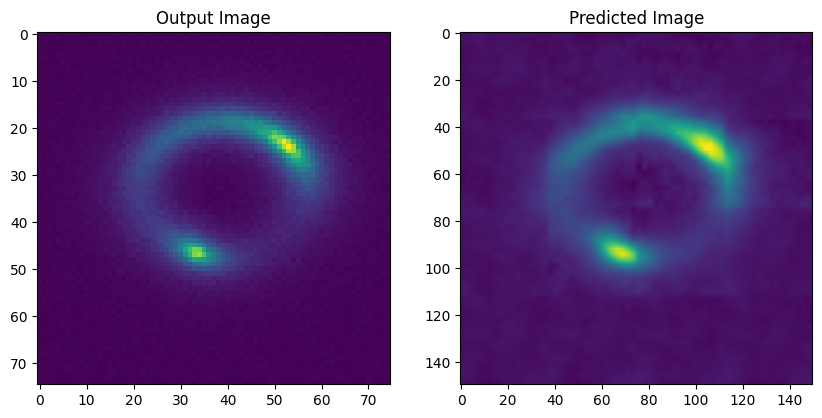

In [59]:
for img_lr, img_hr in train_dataloader:
    image = img_lr.to(device)
    pred = modelSR(image)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(np.array(image[0].squeeze().cpu()))
    ax[0].set_title('Output Image')

    ax[1].imshow(np.array(pred[0].squeeze().squeeze().detach().cpu()))
    ax[1].set_title('Predicted Image')
    break